### Vorhersage des GameStop Aktienkurses mit einem Rekurrenten neuronalen Netz

In diesem Notebook ist die Vorhersage
des Gamestop-Kurses mit einem rekurrenten Netz
in Python dokumentiert.

#### Rekurrente neuronale Netze

Rekurrente neuronale Netze beschreiben eine Familie von neuronalen Netzen
 für das Verarbeiten sequentieller Daten. Sie sind beispielsweise geeignet
 für die Vorhersage von Textsequenzen oder Zeitreihen. (vgl. Ian Goodfellow et al, Deep Learning, S. 365f)

Rekurrente neuronale Netze haben in der Regel je Zeitschritt eine Funktion,
welches als Input die Funktion des vorherigen Zeitschrittes erhält, und als
Output für die nächste Funktion dient:

![alt text](https://i.stack.imgur.com/BAgBq.jpg "RNN")
(Quelle: https://stats.stackexchange.com/questions/392112/tool-to-draw-neural-network-directed-graphs)
#### Architektur

Die Familie der rekurrenten Netze bietet eine Fülle von Architekturen für die
Zellen (auch genannt Neuronen oder Einheiten). In der Praxis haben sich insbesondere Architekturen mit "gated-cells" bewährt. Wodurch die Zellen mehr Kontrolle
beim Lernen haben, indem sie beispielsweise durch ein Forget-Gate entscheiden, welche Informationen sie sich merken oder
vergessen wollen.

Ich habe mich für eine Long short-term
memory Architektur entschieden, da sich diese im Allgemeinen und insbesondere im Aktienbereich bewährt hat
und auch in der Theorie eine gute Wahl darstellen sollte (vgl. Ian Goodfellow et al, Deep Learning, S. 397ff)

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/Long_Short_Term_Memory.png/400px-Long_Short_Term_Memory.png "LSTM")

Grober Aufbau einer LSTM-Zelle, Quelle: https://de.wikipedia.org/wiki/Long_short-term_memory

#### Hinweis

Die Zellen müssen alle nacheinander in richtiger Reihenfolge ausgeführt werden, da teilweise auf Daten und Imports vorheriger Zellen zurückgegriffen wird.

### Vorhersage mit den Kursdaten als einziges Feature

Um den Einfluss der reddit Kommentare und Postings zu erkennen versuchen wir erst den Kurs nur mit der vorherigen
Kursentwicklung vorherzusagen, um dieses Ergebnis mit den späteren Ergebnissen zu vergleichen.

Die Daten sehen wie folgt aus:

In [1]:
import pandas as pd
df = pd.read_csv("../input/GME_04Jan_11May.csv")
print("Anzahl der Zeilen und Spalten:", df.shape)
df.head(5)

Anzahl der Zeilen und Spalten: (89, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,19.000000,19.100000,17.15,17.250000,17.250000,10022500
1,2021-01-05,17.350000,18.080000,17.23,17.370001,17.370001,4961500
2,2021-01-06,17.340000,18.980000,17.33,18.360001,18.360001,6056200
3,2021-01-07,18.469999,19.450001,18.02,18.080000,18.080000,6129300
4,2021-01-08,18.180000,18.299999,17.08,17.690001,17.690001,6482000


Es handelt sich hierbei um die Daten vom 04.01.2021 - 12.05.2021, abrufbar unter finance.yahoo.com.
Wie schon im Word-Dokument spezifiziert, werden wir den "Close"-Wert vorhersagen, also den Kurs bei Börsenschluss des
jeweiligen Tages.

#### Vorbereitung der Trainingsdaten

Als erstes teilen wir die Daten in Training- und Test auf. Die ersten 60 Datensätze werden die
Trainingsdaten, die letzten 29 die Testdaten. Das entspricht in etwa einem 2:1 Verhältnis.

In [2]:
train_threshold = 60
train_data = df.iloc[:train_threshold, 4:5].values
test_data = df.iloc[train_threshold:, 4:5].values

Um die Performance zu verbessern normalisieren wir die Daten mithilfe des Min-Max Scalers von Scikit-learn. Der Scaler wird an
die Trainingsdaten gefittet. Wir nutzen diesen Scaler später auch für die Testdaten, denn ein erneutes Fitten an die Trainingsdaten
würde dem Netz zusätzliche Informationen über die Struktur der Daten liefern, was das Ergebnis manipulieren würde.

In [3]:
from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = normalizer.fit_transform(train_data)

Als nächstes werden die Trainingsdaten vorbereitet. Für ein LSTM benötigen wir ein
drei-dimensionales Input-Array, bestehend aus Samples x Time Steps x Features.
Ein Sample ist eine Zeitreihe, welche Features zu den jeweiligen Time Steps beinhaltet. Bei uns ist vorerst das einzige Feature der Kurswert zum Close.

Die Größe eines Samples, also die Anzahl der enthaltenen Datenpunkte (timesteps) wird im Code mit der Variable batch_size definiert.

Zur Erklärung der Inputs und allgemeinen praktischen Umsetzung von LSTM in Keras verweise ich auf dieses
 [Schaubild](https://github.com/MohammadFneish7/Keras_LSTM_Diagram) (Quelle: github.com/MohammadFneish7(Keras_LSTM_Diagram). Zu finden im Internetquellen-Ordner.

Ein Sample ist in unserem Fall also eine Zeitreihe von Kurswerten (Anzahl entsprechend der batch_size) am jeweiligen Börsenschluss.

Die beste Architektur, welche wir gefunden haben, hatte eine batch_size von 5, also 5 Timesteps pro Sample.

Unten sieht man beispielhaft anhand von Sample 1 und 2 wie die Inputs aufgebaut sind.

Außerdem werden noch Labels für die Trainingsdaten benötigt, was mit y_train realisiert wird. Das passende label für Sample 1 ist
der letzte Wert von Sample 2, da dieser Wert auf die Zeitreihe von Sample 1 folgt.

In [4]:
# preparing training data
batch_size = 5
import numpy as np
X_train = []
y_train = []
for i in range(batch_size, train_threshold):
    X_train.append(train_data_normalized[i-batch_size:i, 0:1])
    y_train.append(train_data_normalized[i, 0:1])
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print("Sample 1:\n", X_train[0])
print("Sample 2:\n", X_train[1])


Sample 1:
 [[0.        ]
 [0.00036335]
 [0.00336099]
 [0.00251317]
 [0.00133229]]
Sample 2:
 [[0.00036335]
 [0.00336099]
 [0.00251317]
 [0.00133229]
 [0.0081451 ]]


#### Ermitteln der besten Architektur

Ich habe mit einem Skript und einer csv-Datei mit ca. 30 Konfigurationen verschiedene
Architekturen getestet. Jede Architektur wurde 30 mal neu trainiert und der jeweilige mean-absolute-error (MAE) mit den Testdaten ermittelt. Anschließend wurde
 der Durchschnitt der 30 MAE-Werte ermittelt, um für jedes Modell ein
statistisch aussagekräftiges Ergebnis zu haben. Das Skript ist im src Ordner zu finden. Die Architektur Konfigurationen und die Ergebnisse im input Ordner.

Das Skript heißt mass_training_model.py und die csv-Dateien rnn_model_configs.csv und rnn_configs_with_mae.csv.

Hier ein kurzer Überblick über die besten Ergebnisse:

    batch_size   neurons   layers   epochs        MAE
20           5        10        3      200   9.381437
22          10        10        3      200   9.834293
15          20        20        2      200   9.973893
8           20        20        1      100  10.111584
16          15        20        2      150  10.153545


Text(0, 0.5, 'MAE')

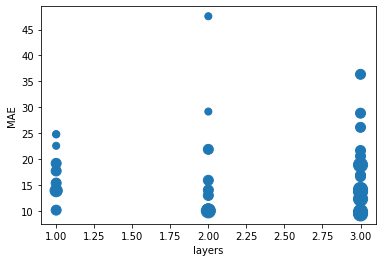

In [5]:
import pandas as pd
config_with_mae = pd.read_csv("../input/rnn_model_configs_with_MAE_onlyClose")
config_with_mae = config_with_mae.sort_values("MAE", axis=0, ascending=True)
print(config_with_mae.iloc[:, 1:6].head(5))

from matplotlib import pyplot

pyplot.scatter(config_with_mae[" layers"], config_with_mae["MAE"], config_with_mae[" epochs"])

pyplot.xlabel("layers")
pyplot.ylabel("MAE")

Man sieht also, dass Architekturen mit drei Layern die besten Ergebnisse hatten. Mit etwas mehr Epochen
konnte man bei diesen Architekturen sogar noch bessere Ergebnisse erzielen. Die Größe der Punkte im Plot steht für die Anzahl der Lernepochen.
 Egal bei welcher Architektur, scheinen viele Epochen von Vorteil für die Ergebnisse zu sein.

Die beste Architektur ist
eine mit einer geringen batch_size, obwohl sonst eigentlich eher große batch_sizes zu guten Vorhersageergebnissen geführt haben.

#### Bauen des Netzes

Folgende Architektur bzw. Parameter hatten das beste Ergebnis:

Neuronen: 10

Layer: 3

batch_size: 5

epochs: 300 (in der Test csv nur mit 200 getestet, bei 300 war das Ergebnis aber noch mal etwas besser)

Zur Vermeidung von Overfitting wird ein Dropout-Layer
nach jedem hidden Layer ebenfalls hinzugefügt. Das ist bei kleineren
 Datensätzen sehr hilfreich.

Um die Architektur bzw. Parameter des Netzes zum Testen dynamisch anzupassen, habe ich folgende Funktion gebaut. Das Training kann ein paar Minuten dauern.


In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

neurons = 10
epochs = 300
hidden_layers = 3

def build_model(number_hidden_layers, number_neurons, number_epochs):
    # Sequential = recurrent
    model = Sequential()

    # adding hidden LSTM layers as specified in parameter
    for i in range(1, number_hidden_layers + 1):
        if i == number_hidden_layers and number_hidden_layers == 1:
            model.add(LSTM(units=number_neurons, return_sequences=False, input_shape=
            (X_train.shape[1], X_train.shape[2])))
            model.add(Dropout(0.2))
        elif i == 1:
            model.add(LSTM(units=number_neurons, return_sequences=True, input_shape=
            (X_train.shape[1], X_train.shape[2])))
            model.add(Dropout(0.2))
        elif i == number_hidden_layers:
            model.add(LSTM(units=number_neurons, return_sequences=False))
            model.add(Dropout(0.2))
        else:
            model.add(LSTM(units=number_neurons, return_sequences=True))
            model.add(Dropout(0.2))

    # output layer
    model.add(Dense(units=1))

    # compiling and training
    model.compile(optimizer="adam", loss="mean_absolute_percentage_error")
    model.fit(X_train, y_train, epochs=number_epochs, batch_size=1)

    return model

model = build_model(hidden_layers, neurons, epochs)

Epoch 1/300
55/55 [==============================] - 0s 3ms/step - loss: 87.3279
Epoch 2/300
55/55 [==============================] - 0s 3ms/step - loss: 57.0632
Epoch 3/300
55/55 [==============================] - 0s 3ms/step - loss: 76.9699
E

Das letzte Layer muss immer den Parameter return_sequences=false gesetzt haben, damit wir am Ende auch die Vorhersage für einen Tag bekommen und
nicht wieder eine Sequenz. Bei dem ersten Layer, muss die input shape als
Parameter mitgegeben werden.

Die batch_size, welche als Parameter model.fit übergeben wird, ist nicht zu verwechseln mit der batch_size der Samplegröße (Anzahl der timesteps je sample). Die batch_size
bei model.fit gibt an, wie häufig der Gradient in einer Epoche berechnet wird, also nach wie vielen Samples
das Netz korrigiert wird. Es wurde eine batch_size von 1 gewählt, da diese durch die Test und Trainingsmenge teilbar sein muss.
Das führt zwar dazu, dass der Gradient unpräziser wird und mehr hin und her "springt", macht das Training des Netzes aber
auch schneller und effizienter (vgl. https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/). Es kann somit zwischen einzelnen Trainings zu stärkeren Abweichungen in den metrics kommen, weswegen
die Modelle auch je 30 mal trainiert wurden, um dann einen Durchschnitt zu finden. Wenn also das Ergebnis der Metrics weiter unten stark abweicht vom erwarteten,
könnte man das Netz erneut trainieren und prüfen, ob das Ergebnis besser wird.

#### Evaluation des Netzes

Da wir nun ein trainiertes Modell haben, können wir es mit den Testdaten evaluieren. Hierfür müssen wir zuerst die
Testdaten vorbereiten, ähnlich wie wir es mit den Trainingsdaten gemacht haben.

Es wird ein Array aus dem DataFrame gebaut, welches ab dem test_threshold(60) abzüglich der batch_size(5) startet. Also in diesem
Fall 60-5 = 55 -> Das Array besteht also aus den letzten 34 Werten (df[55:]). Die batch_size wird abgezogen,
da die ersten Werte entsprechend der batch_size ja nicht vorhergesagt werden. Das trainierte Modell kennt diese Werte zwar,
da diese die letzten Werte des Trainingsdatensatzes darstellen, weiß aber nicht was darauf folgt. Es hat also keine labels zu
den Testdaten gesehen. Wir sagen also mit einem input von 34 Werten nur 29 (Länge des Testdatensatzes) vorraus.


In [7]:
inputs = df.iloc[:, 4:5]
inputs = inputs[len(inputs) - len(test_data) - batch_size:].values
inputs = inputs.reshape(-1, 1)
inputs = normalizer.transform(inputs)

X_test = []
for i in range(batch_size, len(inputs)):
    X_test.append(inputs[i - batch_size:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Da wir nun die Test-Inputs vorbereitet haben, können wir Vorhersagen machen und diese mit den wahren Werten vergleichen. Vorher müssen wir diese natürlich
in ihre ursprüngliche Form wieder retransformieren.

In [8]:
predicted_stock_price = model.predict(X_test)

predicted_stock_price = normalizer.inverse_transform(predicted_stock_price)

for i in range(len(predicted_stock_price)):
    print("Timestep=%d, Predicted=%f, Actual=%f" % (i+1, predicted_stock_price[i], test_data[i]))

Timestep=1, Predicted=200.389969, Actual=189.820007
Timestep=2, Predicted=190.863953, Actual=191.449997
Timestep=3, Predicted=196.902084, Actual=186.949997
Timestep=4, Predicted=188.889114, Actual=184.500000
Timestep=5, Predicted=188.524384, Actual=177.970001
Timestep=6, Predicted=180.498505, Actual=170.259995
Timestep=7, Predicted=173.137085, Actual=158.360001
Timestep=8, Predicted=159.572144, Actual=141.089996
Timestep=9, Predicted=139.786774, Actual=140.990005
Timestep=10, Predicted=141.788162, Actual=166.529999
Timestep=11, Predicted=173.797836, Actual=156.440002
Timestep=12, Predicted=159.187195, Actual=154.690002
Timestep=13, Predicted=159.965546, Actual=164.369995
Timestep=14, Predicted=170.690964, Actual=158.529999
Timestep=15, Predicted=162.508713, Actual=158.509995
Timestep=16, Predicted=163.861481, Actual=151.169998
Timestep=17, Predicted=153.785065, Actual=151.179993
Timestep=18, Predicted=155.257721, Actual=168.929993
Timestep=19, Predicted=176.640884, Actual=177.770004
Ti

In der Tabellenform sehen die Abweichungen recht passabel aus. Wir stellen
sie nun in einem Plot dar, für einen besseren Überblick:

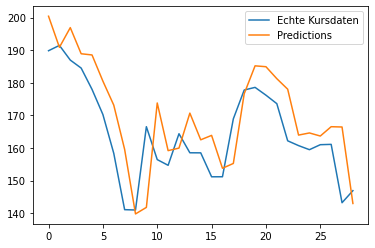

In [9]:
from matplotlib import pyplot

pyplot.plot(test_data, label="Echte Kursdaten")
pyplot.plot(predicted_stock_price, label="Predictions")
pyplot.legend()
pyplot.show()


Anhand des Plots kann man erkennen, dass das Modell anscheinend
dem Trends des Kurses gut, wenn auch etwas zeitverzögert, folgen kann.

Schauen wir uns nun noch die bereits im Word-Dokument definierten Metrics zum Vergleich an. Die metric
mean-directional-accuracy (MDA) zeigt an, wie oft das Modell die Richtung des Kurses am nächsten Tag vorhersagen konnte, also
ob er steigt oder sinkt. Leider hat sci-kit learn hierfür keine Implementation, weswegen
wir die metric noch einmal hier als Funktion einfügen müssen.

In [10]:
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

from sklearn import metrics
# Metrics
print("MAE:", metrics.mean_absolute_error(test_data, predicted_stock_price))
print("MAPE:", metrics.mean_absolute_percentage_error(test_data, predicted_stock_price) * 100)
print("MDA", mda(test_data, predicted_stock_price) * 100)

MAE: 8.979172239729255
MAPE: 5.56285599862552
MDA 67.85714285714286


Die Ergebnisse sollten etwa in dieser Größenordnung sein, wenn man etwas Glück mit dem Gradienten hatte:

MAE: 6-7

MAPE: ca. 4%

MDA: ca 60%

Sollte das Ergebnis stark abweichen könnte man versuchen das Modell noch mal zu trainieren, da es
aufgrund der geringen batch_size beim Aufruf von model.fit beim Training zu zufälligen Abweichungen kommen kann.

Eine MDA von ca. 60% ist für die Vorhersage eines Aktienkurses sehr gut.
Kurzfristige Entwicklungen in Aktienpreisen sind normalerweise extrem schwer vorherzusagen. Mit 60 % ist man
10 % besser als bei einem Münzwurf, wenn man die Richtung des Kurses vorhersagen möchte.

MAPE steht für den mean absolute percentage error, welcher einfach den Mean-absolute-error in Verhältnis
zu den Größen im Datensatz setzt, wir haben also eine durchschnittliche Abweichung von ca. 4%.

Schauen wir uns außerdem noch ein paar Kennzahlen des Datensatzes an, um die Metriken
besser interpretieren zu können.

Hierzu habe ich noch eine Methode geschrieben, welche die durchschnittliche Änderung von einem Kurstag zum nächsten berechnet. In diesem Fall für den Testdatensatz, um
es mit den Abweichung unseres Modells von den wahren Werten vergleichen zu können.


In [11]:
def compute_average_change_per_timestep(data):

    """
    Computes average change from one timestep to the other in a set of values
    :param data: one column of values
    :return: average change
    """
    sum = 0
    for i in range(1, len(data)):
        sum += np.sqrt((data[i, 0] - data[i - 1, 0]) ** 2)
    sum = sum / (len(data) - 1)
    return sum

all_close_values = df.iloc[:, 4:5].values

print("standard deviation: ", np.std(all_close_values))
print("mean:", np.mean(all_close_values))

test_close_values = df.iloc[train_threshold - batch_size:, 4:5].values

print("average price change per day test data:", compute_average_change_per_timestep(test_close_values))


standard deviation:  74.52908816735152
mean: 132.42629215730335
average price change per day test data: 8.070908666666668


Die recht hohe Standardabweichung im Verhältnis zum mean zeigt, dass
der Aktienkurs eine hohe Volatilität aufweist, was unseren Modellen eine genaue Prädiktion natürlich erschwert.

Das wir mit unserem MAE unter dem average price change per day liegen, zeigt, dass das Modell einen gewissen Trend
in den Daten erkannt hat und die Kursentwicklung zu einem gewissen Maße vorhersagen kann.


Falls das Ergebnis des besten Netzes nicht nachstellbar gewesen sein sollte, kann man auch noch das Modell mit dem besten Ergebnis einlesen, ohne es vorher
trainieren zu müssen und dieses evaluieren. Es sollten folgende Metrics sein:

MAE: 6.516182282260237

MAPE: 4.06202344316333

MDA 60.71428571428571

MAE: 6.516182282260237
MAPE: 4.06202344316333
MDA 60.71428571428571


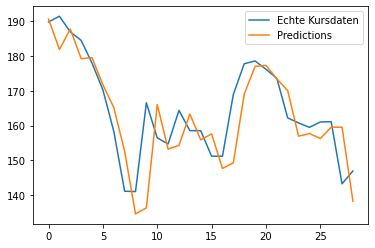

In [12]:
from tensorflow import keras
model = keras.models.load_model("../models/best_close_model")

predicted_stock_price = model.predict(X_test)
predicted_stock_price = normalizer.inverse_transform(predicted_stock_price)

print("MAE:", metrics.mean_absolute_error(test_data, predicted_stock_price))
print("MAPE:", metrics.mean_absolute_percentage_error(test_data, predicted_stock_price) * 100)
print("MDA", mda(test_data, predicted_stock_price) * 100)

pyplot.plot(test_data, label="Echte Kursdaten")
pyplot.plot(predicted_stock_price, label="Predictions")
pyplot.legend()
pyplot.show()

Aus meiner Sicht kann man mit den Metrics durchaus zufrieden sein, wenn man das sonst hohe Zufallsrauschen kurzfristiger Aktienentwicklungen bedenkt.
Außerdem wurde ja bisher nur ein Feature zur Vorhersage genutzt. Schauen wir im nächsten Abschnitt, ob sich die Vorhersage mit einem 2. Feature, der Anzahl
von Kommentaren mit GameStop Bezug im wallstreetbets-Subreddit, verbessern lässt.


### Vorhersage mit den Kursdaten und Anzahl der Reddit-Postings als Feature

#### Feature-Mapping

Um die Vorhersage mit beiden Features machen zu können, wurde diese gemappt und in einer CSV gespeichert. Das Skript lässt sich im Anhang
im src Ordner finden "mapping_close_and_reddit_data.py". Die gemappte CSV sieht folgendermaßen aus:


In [13]:
import pandas as pd
df = pd.read_csv("../input/GME_CloseAndReddit_previous_polish_04Jan_11May.csv")
print("Anzahl der Zeilen und Spalten:", df.shape)
df.head(5)

Anzahl der Zeilen und Spalten: (89, 4)


,Unnamed: 0,Date,Close,Anzahl
0,0,2021-01-04,17.250000,1483
1,1,2021-01-05,17.370001,1144
2,2,2021-01-06,18.360001,1063
3,3,2021-01-07,18.080000,929
4,4,2021-01-08,17.690001,983


"Close" ist der Kurs und "Anzahl" die
Anzahl der Reddit Kommentare mit GameStop Bezug am jeweiligen Tag. Es bleiben weiterhin 89 Zeitschritte, damit
die Ergebnisse vergleichbar bleiben.

Der Großteil des Codes bleibt auch bei zwei Features gleich, es wird im Folgenden
dementsprechend nur auf Abweichungen eingegangen.

#### Vorbereitung der Trainingsdaten

Zunächst wieder wie oben die Einteilung in Test und Trainingsdaten, lediglich die Spalten, aus denen wir die Features ziehen, haben sich hier geändert:

In [14]:
train_threshold = 60
# read in csv and divide data into train and test
df = pd.read_csv("../input/GME_CloseAndReddit_previous_polish_04Jan_11May.csv")
train_data = df.iloc[:train_threshold, 2:4].values
test_data = df.iloc[train_threshold:, 2:3].values


Dann wieder die Normalisierung der Daten genauso wie bei einem Feature.

In [15]:
# normalize data
normalizer = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = normalizer.fit_transform(train_data)

Nun werden die Trainingsdaten wieder in eine 3-Dimensionale Form (3-D-Numpy-Array) gebracht. Dieses besteht nun aus 50 Samples x 10 Time Steps (batch_size) x 2 Features.

Interessanterweise haben bei zwei Features vollkommen andere Architekturen die besten Ergebnisse erzielt, weswegen nun pro Sample 10 Time Steps genommen werden.


In [16]:
batch_size = 10
# transform data for input in model
X_train = []
y_train = []
for i in range(batch_size, train_threshold):
    X_train.append(train_data_normalized[i - batch_size:i, 0:2])
    y_train.append(train_data_normalized[i, 0:1])
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))

print("Shape:", X_train.shape)

print("Sample 1:\n", X_train[0])
print("Sample 2:\n", X_train[1])

Shape: (50, 10, 2)
Sample 1:
 [[0.         0.01376819]
 [0.00036335 0.01026938]
 [0.00336099 0.00943338]
 [0.00251317 0.00805037]
 [0.00133229 0.0086077 ]
 [0.0081451  0.02188048]
 [0.00817538 0.00976365]
 [0.04284503 0.11233357]
 [0.06861261 0.1523377 ]
 [0.05525949 0.15392713]]
Sample 2:
 [[0.00036335 0.01026938]
 [0.00336099 0.00943338]
 [0.00251317 0.00805037]
 [0.00133229 0.0086077 ]
 [0.0081451  0.02188048]
 [0.00817538 0.00976365]
 [0.04284503 0.11233357]
 [0.06861261 0.1523377 ]
 [0.05525949 0.15392713]
 [0.06694725 0.09770874]]


#### Ermitteln der besten Architektur

Bevor das Netz gebaut wird, werden vorher noch einmal die besten Architekturen gezeigt.
Hierfür wurden wieder mit einem Skript ca. 30 verschiedene Architekturen 30 mal trainiert,
um für jede Architektur einen durchschnittlichen MAE-Wert zu bekommen. Das Skript ist im Anhang unter src zu finden
"mass_training_model_redditAndClose.py". Die Ergebnisse sind in der csv "rnn_model_configs_with_MAE_closeAndReddit" zu finden.

Hier die besten 5 Ergebnisse:

    batch_size   neurons   layers   epochs        MAE
0           10        10        1      100   7.786497
5            5         5        1      300   9.078880
1           10        10        1      300   9.666403
4            5         5        1      100  14.255390
20          10        10        3      100  15.725581


Text(0, 0.5, 'MAE')

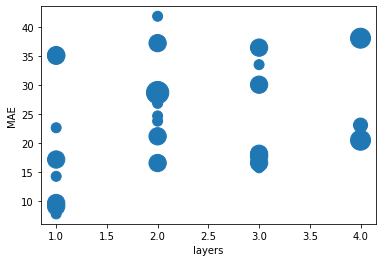

In [17]:
import pandas as pd
config_with_mae = pd.read_csv("../input/rnn_model_configs_with_MAE_closeAndReddit")
config_with_mae = config_with_mae.sort_values("MAE", axis=0, ascending=True)
print(config_with_mae.iloc[:, 1:6].head(5))

from matplotlib import pyplot

pyplot.scatter(config_with_mae[" layers"], config_with_mae["MAE"], config_with_mae[" epochs"])

pyplot.xlabel("layers")
pyplot.ylabel("MAE")

Wie man sieht, ist das Ergebniss nun ein vollkommen anderes, als bei nur einem Feature. Bei zwei Features haben die 1-Layer Netze mit Abstand am besten
abgeschnitten. Die multi-layer Netze performen deutlich schlechter. Auch an den Punkten kann man erkennen, dass dieses mal eher wenig Lernepochen zu einem
guten Ergebnis geführt haben.

Die Ergebnisse der Vorhersagen haben sich bei den besten Architekturen im Schnitt deutlich verbessert.

Bei der 1-Feature-Vorhersage war das beste Netz bei einer MAE von ca. 9,38 gegen ein Ergebnis von ca. 7,79 bei 2 Features.

Interessant ist außerdem, dass hier nur 100 Trainingsepochen für das beste Ergebnis benötigt wurden. Die Netze,
welche zwei Features zur Vorhersage bekommen, scheinen also stärker zu overfitting zu neigen.

Erwähnbar ist noch das Ergebnis eines 5-Layer Netzes, welches ich einmal Stichprobenartig getestet habe:

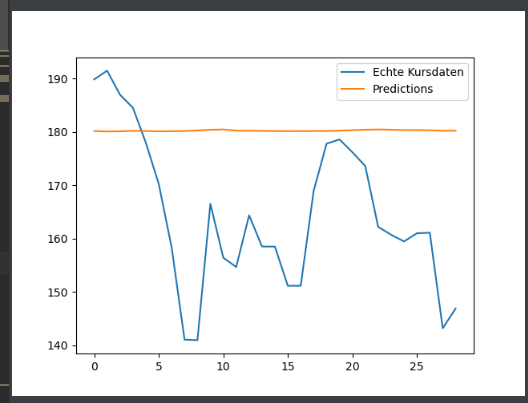

In [18]:
from IPython.display import Image
Image(filename='../pictures/5_layer_prediction.png')

Das Modell hat scheinbar gelernt, dass es den geringsten Fehler erzeugt, wenn es einfach gar nicht versucht dem Trend zu folgen,
sondern einfach ca. denselben Wert beibehält.

#### Bauen des Netzes

Da wir nun wissen, welche Architektur benötigt wird, kann das Netz gebaut werden.

Hier hat sich, außer der Modellparameter, nichts geändert. Wir rufen also einfach die Methode, welche weiter oben bereits beschrieben wurde,
mit den neuen Parametern auf:



In [19]:
neurons = 10
epochs = 100
hidden_layers = 1

model = build_model(hidden_layers, neurons, epochs)

Epoch 1/100
50/50 [==============================] - 0s 2ms/step - loss: 67.6941
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 57.3344
Epoch 3/100
50/50 [==============================] - 0s 2ms/step - loss: 50.1171
Epoch 4/100
50/50 [==============================] - 0s 2ms/step - loss: 43.7221
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: 45.5961

Das Training ging nun deutlich schneller, aufgrund der simpleren Netzarchitektur und der Anzahl der Epochen.

#### Evaluation des Netzes

Analog zu den Testdaten, müssen die Trainingsdaten noch vorbereitet werden.

In [20]:
X_test = []
inputs = df.iloc[:, 2:4]
inputs = inputs[len(inputs) - len(test_data) - batch_size:].values
inputs = inputs.reshape(-1, 2)
inputs = normalizer.transform(inputs)

for i in range(batch_size, len(inputs)):
    X_test.append(inputs[i - batch_size:i, 0:2])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))

Anschließend werden Vorhersagen gemacht, welche wieder in ihre ursprüngliche Form zurück transformiert werden.

Da der MinMaxScaler auf zwei Features gefittet ist müssen wir dem Array mit den Vorhersagewerten
noch die Anzahl der Reddit Kommentare hinzufügen, welche wir nach der inversen Transformation aber nicht mehr benötigen.


In [21]:
predicted_stock_price = model.predict(X_test)
second_feature = np.array(df.iloc[train_threshold:, 3:4].values)
predicted_stock_price_with_2nd_feature = np.column_stack((predicted_stock_price, second_feature))
predicted_stock_price_with_2nd_feature = normalizer.inverse_transform(predicted_stock_price_with_2nd_feature)
predicted_stock_price = predicted_stock_price_with_2nd_feature[:, 0]

Zuerst schauen wir uns wieder die Vorhersagen im Vergleich zu den wahren Kurswerten in einer Tabelle an:

In [22]:
for i in range(len(predicted_stock_price)):
    print("Timestep=%d, Predicted=%f, Actual=%f" % (i+1, predicted_stock_price[i], test_data[i]))


Timestep=1, Predicted=183.885752, Actual=189.820007
Timestep=2, Predicted=184.262996, Actual=191.449997
Timestep=3, Predicted=184.861598, Actual=186.949997
Timestep=4, Predicted=183.246579, Actual=184.500000
Timestep=5, Predicted=179.851522, Actual=177.970001
Timestep=6, Predicted=175.544378, Actual=170.259995
Timestep=7, Predicted=170.610187, Actual=158.360001
Timestep=8, Predicted=161.918459, Actual=141.089996
Timestep=9, Predicted=149.253366, Actual=140.990005
Timestep=10, Predicted=143.404648, Actual=166.529999
Timestep=11, Predicted=154.898128, Actual=156.440002
Timestep=12, Predicted=155.590588, Actual=154.690002
Timestep=13, Predicted=155.951690, Actual=164.369995
Timestep=14, Predicted=159.367102, Actual=158.529999
Timestep=15, Predicted=157.122162, Actual=158.509995
Timestep=16, Predicted=156.808087, Actual=151.169998
Timestep=17, Predicted=153.444073, Actual=151.179993
Timestep=18, Predicted=152.161377, Actual=168.929993
Timestep=19, Predicted=161.931057, Actual=177.770004
Ti

Die Abweichungen sehen auf den ersten Blick wieder einigermaßen
passabel aus. Um es genauer zu sehen, wird wieder ein Plot erzeugt:


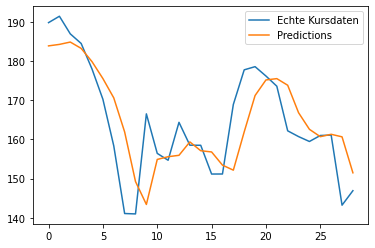

In [23]:
from matplotlib import pyplot

pyplot.plot(test_data, label="Echte Kursdaten")
pyplot.plot(predicted_stock_price, label="Predictions")
pyplot.legend()
pyplot.show()

Der Plot sieht sehr gut aus. Die Abweichungen sind akzeptabel und dem Trend wird, leicht verzögert, sehr gut gefolgt.

Nun die Metrics:

In [24]:
from sklearn import metrics
# Metrics
print("MAE:", metrics.mean_absolute_error(test_data, predicted_stock_price))
print("MAPE:", metrics.mean_absolute_percentage_error(test_data, predicted_stock_price) * 100)
print("MDA", mda(test_data, predicted_stock_price) * 100)


MAE: 6.73642052769529
MAPE: 4.192014051328051
MDA 53.06122448979592


Wie schon in der CSV gesehen, sind die Metrics des Netzes, welches mit zwei Features trainiert wurde, besser.

Das Netz konnte also durch die Hinzunahme der Anzahl der Reddit-Kommentare zu Gamestop an den jeweiligen Tagen seine Vorhersagen verbessern.

Die Hypothese, dass diese Kommentare mit der Kursentwicklung zusammen hängen, ist somit bestätigt.

Aus meiner Sicht ist dieses Ergebnis sehr zufriedenstellend, wenn man die normalerweise unberechenbare Natur von Aktienkursen bedenkt, denn die durchschnittliche
prozentuale Abweichung der Vorhersage liegt nur bei 4-5%! Es wird außerdem öfter als in 50% der Fälle die Richtung des Aktienkurses richtig vorhergesagt. Aus meiner Sicht
ist bei Aktien alles über 50% für die Richtung des Kurses ein gutes Ergebnis, da Aktienkursentwicklungen kurzfristig normalerweise nicht vorhersehbar sind. (Quelle: https://de.wikipedia.org/wiki/Markteffizienzhypothese)

Um zu zeigen wie das Modell im besten Fall performen kann, wird noch mal ein außergewöhnlich gutes Modell importiert:


MAE: 6.174529053306612
MAPE: 3.8570587907027707
MDA 57.14285714285714


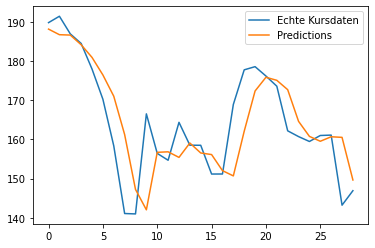

In [25]:
from tensorflow import keras
model = keras.models.load_model("../models/best_closeAndReddit_model")

predicted_stock_price = model.predict(X_test)
predicted_stock_price_with_2nd_feature = np.column_stack((predicted_stock_price, second_feature))
predicted_stock_price_with_2nd_feature = normalizer.inverse_transform(predicted_stock_price_with_2nd_feature)
predicted_stock_price = predicted_stock_price_with_2nd_feature[:, 0]

from sklearn import metrics
# Metrics
print("MAE:", metrics.mean_absolute_error(test_data, predicted_stock_price))
print("MAPE:", metrics.mean_absolute_percentage_error(test_data, predicted_stock_price) * 100)
print("MDA", mda(test_data, predicted_stock_price) * 100)

from matplotlib import pyplot

pyplot.plot(test_data, label="Echte Kursdaten")
pyplot.plot(predicted_stock_price, label="Predictions")
pyplot.legend()
pyplot.show()

### Fazit

Zusammenfassend lässt sich sagen, dass ich von den
Ergebnissen sowohl bei nur einem als auch bei zwei Features positiv überrascht bin.
Die Ergebnisse sind deutlich besser als ich es erwartet habe, vor allem bei nur einem Feature.

Weiterhin hat sich die Hypothese, dass die Reddit-Kommentare die Vorhersage verbessern,
bewahrheitet. So lässt sich das Bauen des rekurennten Netzes definitiv als
Erfolg bewerten. Außerdem hat sich gezeigt, dass mehr Features nicht unbedingt von einer komplexeren
Netz-Architektur profitieren, was ich eigentlich erwartet hätte. Man sollte also immer wenn man den
Datensatz verändert oder neue Features hinzuzieht noch einmal seine Architektur-Entscheidungen neu
evaluieren.

Im Abschluss wird dann noch das Ergebnis dieses Modells mit den Ergebnissen
des Arima- und des Regressionsmodells verglichen.